In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [3]:
# settings
LEARNING_RATE = 1e-4

# set to 20k on local environment to get .99 accuracy
TRAINING_ITERATIONS = 2500

DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 0

#image number to output
IMAGE_TO_DISPLAY = 10

In [4]:
data = pd.read_csv('/Users/hechengwang/GitHub/NN/train.csv')

print 'data({0[0]}, {0[1]})'.format(data.shape)
print data.head

data(42000, 785)
<bound method DataFrame.head of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
5          0       0       0       0       0       0       0       0       0   
6          7       0       0       0       0       0       0       0       0   
7          3       0       0       0       0       0       0       0       0   
8          5       0       0       0       0       0       0       0       0   
9          3       0       0       0       0       0       0       0       0   
10         8       0       0       0       0       0       0       0   

In [5]:
images = data.iloc[:, 1:].values
images = images.astype(np.float)

# convert images from [0:255] to [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print 'images ({0[0]}, {0[1]})'.format(images.shape)

images (42000, 784)


In [6]:
image_size = images.shape[1]
print 'image_size => %s' % (image_size)

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print 'image_width => %s \nimage_height => %s' % (image_width, image_height)

image_size => 784
image_width => 28 
image_height => 28


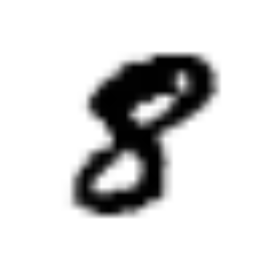

In [7]:
# display image
def display(img):
    
    # 784 = 28x28
    one_image = img.reshape(image_width, image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap = cm.binary)

# output image
display(images[IMAGE_TO_DISPLAY])

In [8]:
labels_flat = data[[0]].values.ravel()

print 'labels_flat %s' % (len(labels_flat))
print 'labels_flat[%s] => %s' % (IMAGE_TO_DISPLAY, labels_flat[IMAGE_TO_DISPLAY])

labels_flat 42000
labels_flat[10] => 8


In [9]:
labels_count = np.unique(labels_flat).shape[0]

print 'labels_count => %s' % (labels_count)

labels_count => 10


In [10]:
# convert class labels from scalars to one-hot vectors

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [11]:
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print 'labels({0[0]}, {0[1]})'.format(labels.shape)
print 'labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY, labels[IMAGE_TO_DISPLAY])

labels(42000, 10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [12]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(42000,784)
validation_images(0,784)


# TensorFlow

We are using [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) neurones (f(x) = max(0, x))

In [13]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

In [21]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

Read all about convolutions [here](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer).

In [23]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Read all about pooling [here](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer)

In [18]:
#images
x = tf.placeholder('float', shape = [None, image_size])

#labels
y_ = tf.placeholder('float', shape = [None, labels_count])

1st Convolutional layer will be size [5, 5] and have 32 features (picked arbitrarily) with 1 input channel (grayscale photos)
1st Pooling layer after convolution will reduce the image from 28x28 to 14x14

In [24]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (42,000 images of size 784 --> 42,000 images of size (28, 28, 1)
image = tf.reshape(x, [-1, image_width, image_height, 1])

# Extract 32 features from 42,000 size 28x28 images
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4, 8))
layer1 = tf.transpose(layer1, (0, 3, 1, 4, 2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8))

<tf.Tensor 'Reshape_5:0' shape=(?, 112, 224) dtype=float32>

In [29]:
# second convolutional layer
# note there are 32 input channels; there were 32 features obtained from the first convolutional layer
# again, 64 features are chosen arbitrarily
# max pooling on a 14x14 image will result in a 7x7 image

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4, 16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4, 2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))

In [30]:
#fully connected layer
#1024 features is an arbitrary number of neurons

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (42000, 7, 7, 64) => (42000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# will result in 42,000 images and 1,024 features for each image

In [31]:
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Go [here](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout) to read all about dropout

Using a [softmax regression](https://en.wikipedia.org/wiki/Softmax_function) we obtain the predicted label based on the activation of the 1024 layers

In [32]:
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

We use [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) to calculate prediction score and the [ADAM optimizer](http://arxiv.org/pdf/1412.6980v8.pdf) to reduce it.

In [33]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [35]:
#transforms prediction probabilities to label values
predict = tf.argmax(y, 1)

# Train, validate and predict

In [36]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [37]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

In [ ]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

In [ ]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [ ]:
# read test data from CSV file 
test_images = pd.read_csv('../input/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

In [27]:
layer1_grid = layer1.eval(feed_dict={x: images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )

NameError: name 'keep_prob' is not defined